In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Make features

In [0]:
MODEL_TYPE = 'TZ_HD'

In [0]:
pass_input= "/content/drive/My Drive/Kaggle/ashrae-energy/input/"
pass_output = "/content/drive/My Drive/Kaggle/ashrae-energy/output/"

In [0]:
# General imports
import numpy as np
import pandas as pd
import os, gc, sys, warnings, random, math, psutil, pickle,datetime

from sklearn.preprocessing import LabelEncoder



# warnings.filterwarnings('ignore')

In [0]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
## Simple "Memory profilersls" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!=TARGET:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
########################### Vars
#################################################################################
SEED = 42
LOCAl_TEST = False
seed_everything(SEED)
TARGET = 'meter_reading'

In [115]:
########################### DATA LOAD
#################################################################################
print('Load Data')
train_df = pd.read_pickle(pass_input + 'train.pkl')
test_df = pd.read_pickle(pass_input +'test.pkl')

building_df = pd.read_pickle(pass_input + 'building_metadata.pkl')

train_weather_df = pd.read_pickle(pass_input + 'weather_train.pkl')
test_weather_df = pd.read_pickle(pass_input + 'weather_test.pkl')

Load Data


In [116]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd61b1f1ac8>]],
      dtype=object)

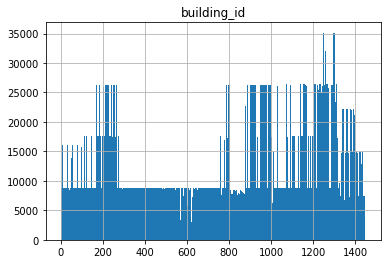

In [117]:
#distribution of id
train_df[['building_id']].hist(bins=int(train_df[['building_id']].max()))

In [0]:
########################### Building DF merge through concat 
#################################################################################
# Benefits of concat:
## Faster for huge datasets (columns number)
## No dtype change for dataset
## Consume less memmory 

temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_df, on=['building_id'], how='left')
del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)

del building_df, temp_df

In [119]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01,0.0,0,0,7432,2008,0
1,1,0,2016-01-01,0.0,0,0,2720,2004,0
2,2,0,2016-01-01,0.0,0,0,5376,1991,0
3,3,0,2016-01-01,0.0,0,0,23685,2002,0
4,4,0,2016-01-01,0.0,0,0,116607,1975,0


In [0]:
########################### Convert timestamplocal to date
#################################################################################
for df in [train_df, test_df]:
    df['DT_M'] = df['timestamp'].dt.month.astype(np.int8)
    df['DT_W'] = df['timestamp'].dt.weekofyear.astype(np.int8)
    df['DT_D'] = df['timestamp'].dt.dayofyear.astype(np.int16)
    
    df['DT_hour'] = df['timestamp'].dt.hour.astype(np.int8)
    df['DT_day_week'] = df['timestamp'].dt.dayofweek.astype(np.int8)
    df['DT_day_month'] = df['timestamp'].dt.day.astype(np.int8)
    df['DT_week_month'] = df['timestamp'].dt.day/7
    df['DT_week_month'] = df['DT_week_month'].apply(lambda x: math.ceil(x)).astype(np.int8)

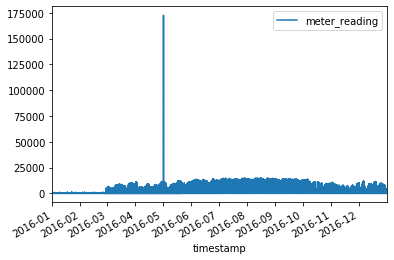

In [121]:
#looks like there may be some errors with some of the readings
#You can change the id number from 0 to 16 and you can see that only when it's 0,
#there's a wierd spike.
# So you'd better delete 0_site_id data when meter_reading == 0 
train_df[train_df["site_id"] == 0].plot("timestamp", "meter_reading")

In [0]:
########################### Remove 0 meter readings for site_id==0
#################################################################################
df = train_df[train_df['site_id']==0]

train_df['drop'] = np.where(train_df['DT_D']<=140, 1, 0)
train_df['drop'] = np.where(train_df['building_id'].isin(df['building_id']), train_df['drop'], 0)

train_df = train_df[train_df['drop']==0].reset_index(drop=True)

del df, train_df['drop']

In [0]:
########################### Add country info
#################################################################################
# According to city prediction made by @patrick0302 in https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature 
#US sites: 0,2,3,4,6,8,9,10,13,14,15, EU sites: 1,5,12, CA sites: 7,11

# US:1, EU:2, CA:3
country = {0:1,1:2,2:1,3:1,4:1,5:2,6:1,7:3,8:1,9:1,10:1,11:3,12:4,13:1,14:1,15:1} 
train_df['country'] = train_df['site_id'].map(country)
test_df['country'] = test_df['site_id'].map(country)


In [0]:
########################### Leak! Convert timezone to GMT.
#################################################################################
# According to city prediction made by @patrick0302 in https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature 
#
#################################################################################
# Arange time in Local Time
# The conclusion multiple people have reached is that weather data is in GMT,
# while meter reading data is in local time.

timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
train_weather_df['timediff']= train_weather_df['site_id'].map(timediff)
test_weather_df['timediff']= test_weather_df['site_id'].map(timediff)

train_weather_df['timediff'] = train_weather_df['timediff'].apply(lambda x: datetime.timedelta(hours=x))
test_weather_df['timediff'] = test_weather_df['timediff'].apply(lambda x: datetime.timedelta(hours=x))

train_weather_df['timestamp'] = pd.to_datetime(train_weather_df['timestamp']) 
test_weather_df['timestamp'] = pd.to_datetime(test_weather_df['timestamp'])

train_weather_df['timestamp'] = train_weather_df['timestamp'] - train_weather_df['timediff'] 
test_weather_df['timestamp'] = test_weather_df['timestamp'] - test_weather_df['timediff']


# #################################################################################
# # # Arange time in GMT
# # For train data
# country = {0:1,1:2,2:1,3:1,4:1,5:2,6:1,7:3,8:1,9:1,10:1,11:3,12:4,13:1,14:1,15:1} 
# train_weather_df['country'] = train_weather_df['site_id'].map(country) 

# timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 
# train_weather_df['time_diff']= train_weather_df['site_id'].map(timediff)

# train_df['DT_hour'] = train_df['DT_hour'] + train_df['time_diff'] 
# train_df.loc[train_df['DT_hour']>23, 'DT_hour'] = train_df[train_df['DT_hour']>23]['DT_hour'] - 24

# #For test data
# country = {0:1,1:2,2:1,3:1,4:1,5:2,6:1,7:3,8:1,9:1,10:1,11:3,12:4,13:1,14:1,15:1} 
# test_weather_df['country'] = test_weather_df['site_id'].map(country) 

# timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 
# test_weather_df['time_diff']= test_weather_df['site_id'].map(timediff)

# test_df['DT_hour'] = test_df['DT_hour'] + test_df['time_diff'] 
# test_df.loc[test_df['DT_hour']>23, 'DT_hour'] = test_df[test_df['DT_hour']>23]['DT_hour'] - 24

In [125]:
train_weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timediff
0,0,2015-12-31 20:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,04:00:00
1,0,2015-12-31 21:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,04:00:00
2,0,2015-12-31 22:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,04:00:00
3,0,2015-12-31 23:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,04:00:00
4,0,2016-01-01 00:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,04:00:00


In [0]:
########################### Weather DF merge over concat (to not lose type)
#################################################################################
# Benefits of concat:
## Faster for huge datasets (columns number)
## No dtype change for dataset
## Consume less memmory 
# 
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(train_weather_df, on=['site_id','timestamp'], how='left')
del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(test_weather_df, on=['site_id','timestamp'], how='left')
del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del train_weather_df, test_weather_df, temp_df

In [127]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day_month,DT_week_month,country,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timediff
0,105,0,2016-01-01,23.3036,1,0,50623,-999,5,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days
1,106,0,2016-01-01,0.3746,1,0,5374,-999,4,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days
2,106,3,2016-01-01,0.0000,1,0,5374,-999,4,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days
3,107,0,2016-01-01,175.1840,1,0,97532,2005,10,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days
4,108,0,2016-01-01,91.2653,1,0,81580,1913,5,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days


In [0]:
########################### Smooth readings
#################################################################################
train_df['s_uid'] = train_df['site_id'].astype(str) +'_'+\
                    train_df['DT_M'].astype(str) +'_'+\
                    train_df['meter'].astype(str) +'_'+\
                    train_df['primary_use'].astype(str)

temp_df = train_df.groupby(['s_uid'])[TARGET].apply(lambda x: int(np.percentile(x,99)))
temp_df = temp_df.to_dict()

train_df['s_uid'] = train_df['s_uid'].map(temp_df)
train_df[TARGET] = np.where(train_df[TARGET]>train_df['s_uid'], train_df['s_uid'], train_df[TARGET])

del train_df['s_uid'], temp_df

In [0]:
########################### Encode Meter
#################################################################################
# Building and site id
for enc_col in ['building_id', 'site_id']:
    temp_df = train_df.groupby([enc_col])['meter'].agg(['unique'])
    temp_df['unique'] = temp_df['unique'].apply(lambda x: '_'.join(str(x))).astype(str)

    le = LabelEncoder()
    temp_df['unique'] = le.fit_transform(temp_df['unique']).astype(np.int8)
    temp_df = temp_df['unique'].to_dict()

    train_df[enc_col+'_uid_enc'] = train_df[enc_col].map(temp_df)
    test_df[enc_col+'_uid_enc'] = test_df[enc_col].map(temp_df)
    
    # Nunique
    temp_dict = train_df.groupby([enc_col])['meter'].agg(['nunique'])['nunique'].to_dict()
    train_df[enc_col+'-m_nunique'] = train_df[enc_col].map(temp_dict).astype(np.int8)
    test_df[enc_col+'-m_nunique'] = test_df[enc_col].map(temp_dict).astype(np.int8)

del temp_df, temp_dict

In [0]:
########################### Daily temperature
#################################################################################
for df in [train_df, test_df]:
    df['DT_w_hour'] = np.where((df['DT_hour']>5)&(df['DT_hour']<13),1,0)
    df['DT_w_hour'] = np.where((df['DT_hour']>12)&(df['DT_hour']<19),2,df['DT_w_hour'])
    df['DT_w_hour'] = np.where((df['DT_hour']>18),3,df['DT_w_hour'])

    df['DT_w_temp'] = df.groupby(['site_id','DT_W','DT_w_hour'])['air_temperature'].transform('mean')
    df['DT_w_dew_temp'] = df.groupby(['site_id','DT_W','DT_w_hour'])['dew_temperature'].transform('mean')

i_cols = [
         'DT_w_hour',
        ]

for col in i_cols:
    del train_df[col], test_df[col]

In [0]:
########################### Add National Holidays depending on contries
#################################################################################
# github.com/peopledoc/workalendar

def add_Holidays(df):
    import holidays
    en_holidays = holidays.England()
    ir_holidays = holidays.Ireland()
    ca_holidays = holidays.Canada()
    us_holidays = holidays.UnitedStates()

    en_idx = df.query('site_id == 1 or site_id == 5').index
    ir_idx = df.query('site_id == 12').index
    ca_idx = df.query('site_id == 7 or site_id == 11').index
    us_idx = df.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

    df['IsHoliday'] = 0
    df.loc[en_idx, 'IsHoliday'] = df.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df.loc[ir_idx, 'IsHoliday'] = df.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df.loc[ca_idx, 'IsHoliday'] = df.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df.loc[us_idx, 'IsHoliday'] = df.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

    holiday_idx = df['IsHoliday'] != 0
    df.loc[holiday_idx, 'IsHoliday'] = 1
    df['IsHoliday'] = df['IsHoliday'].astype(np.uint8)

add_Holidays(train_df)
add_Holidays(test_df)


In [132]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day_month,DT_week_month,country,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timediff,building_id_uid_enc,building_id-m_nunique,site_id_uid_enc,site_id-m_nunique,DT_w_temp,DT_w_dew_temp,IsHoliday
0,105,0,2016-01-01,23.3036,1,0,50623,-999,5,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days,8,1,6,2,6.55,5.422222,1
1,106,0,2016-01-01,0.3746,1,0,5374,-999,4,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days,7,2,6,2,6.55,5.422222,1
2,106,3,2016-01-01,0.0000,1,0,5374,-999,4,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days,7,2,6,2,6.55,5.422222,1
3,107,0,2016-01-01,175.1840,1,0,97532,2005,10,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days,8,1,6,2,6.55,5.422222,1
4,108,0,2016-01-01,91.2653,1,0,81580,1913,5,1,53,1,0,4,1,1,2,3.8,NaN,2.4,NaN,1020.9,240.0,3.1,0 days,8,1,6,2,6.55,5.422222,1


In [0]:
########################### Delete some columns
#################################################################################
# del test_df['row_id']

i_cols = [
         'timestamp',
          'timediff',
          'DT_D',
         'DT_day_month',
         'DT_week_month',
        ]

for col in i_cols:
    try:
        del train_df[col], test_df[col]
    except:
        print("Couldn't delete :" + str(col))
        pass

In [134]:
########################### Reduce memory usage
#################################################################################
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 907.57 Mb (54.3% reduction)
Mem. usage decreased to 1749.70 Mb (56.4% reduction)


In [0]:
########################### Trick to use kernel hdd to store results
#################################################################################

# You can save just test_df or both if have sufficient space
train_df.to_pickle(pass_input + 'train_df_' + MODEL_TYPE +'.pkl')
test_df.to_pickle(pass_input + 'test_df_' + MODEL_TYPE +'.pkl')
   
# del train_df, test_df
# gc.collect()

In [136]:
########################### Check memory usage
#################################################################################
for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))
print('Memory in Gb', get_memory_usage())

                       test_df:   1.7GiB
                            df:   1.7GiB
                      train_df: 907.6MiB
                          _102:   6.2KiB
                          _105:   6.2KiB
                          _i21:   2.3KiB
                          _i50:   2.3KiB
                          _i78:   2.3KiB
                         _i113:   2.3KiB
                          _i34:   1.9KiB
Memory in Gb 25.27


In [137]:
train_df.dtypes

building_id                int16
meter                       int8
meter_reading            float64
site_id                     int8
primary_use                 int8
square_feet                int32
year_built                 int16
floor_count                 int8
DT_M                        int8
DT_W                        int8
DT_hour                     int8
DT_day_week                 int8
country                     int8
air_temperature          float16
cloud_coverage           float16
dew_temperature          float16
precip_depth_1_hr        float16
sea_level_pressure       float16
wind_direction           float16
wind_speed               float16
building_id_uid_enc         int8
building_id-m_nunique       int8
site_id_uid_enc             int8
site_id-m_nunique           int8
DT_w_temp                float16
DT_w_dew_temp            float16
IsHoliday                  uint8
dtype: object